# Example notebook

Bubble tracks.


In [ ]:
# %matplotlib widget

from boilercv.docs import FLOAT_SPEC, HIDE, init, nowarn, style_df  # noqa: F401

init()
%precision %$FLOAT_SPEC

from typing import TypedDict
from warnings import catch_warnings

import janitor  # noqa: F401  # magically registers methods on pandas objects
import numpy as np
import pandas as pd
import seaborn as sns
from boilercv.correlations import (
    dimensionless_bubble_diameter_florschuetz,
    dimensionless_bubble_diameter_inaba,
    dimensionless_bubble_diameter_yuan,
    fourier,
    jakob,
    kinematic_viscosity,
    prandtl,
    reynolds,
    thermal_diffusivity,
)
from boilercv.data import islice
from boilercv.data.sets import get_dataset
from boilercv.images import scale_bool
from boilercv.images.cv import Op, Transform, transform
from matplotlib import pyplot as plt

with nowarn(capture=True):
    import trackpy as tp

tp.quiet()

In [ ]:
def get_image_boundaries(img) -> tuple[tuple[int, int], tuple[int, int]]:
    # https://stackoverflow.com/a/44734377/20430423
    dilated = transform(img, Transform(Op.dilate, 12))
    cols = np.any(dilated, axis=0)
    rows = np.any(dilated, axis=1)
    ylim = tuple(np.where(rows)[0][[0, -1]])
    xlim = tuple(np.where(cols)[0][[0, -1]])
    return ylim, xlim


def crop_image(img, ylim, xlim):
    return img[ylim[0] : ylim[1] + 1, xlim[0] : xlim[1] + 1]


def show_initial_and_path(video):
    """Show the initial frame and the path thereafter."""
    first_frame = video.sel(frame=0).values
    composite_video = video.max("frame").values
    ylim, xlim = get_image_boundaries(composite_video)
    _, ax = plt.subplots()
    ax.imshow(~first_frame, alpha=0.8)
    ax.imshow(~composite_video, alpha=0.4)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.invert_yaxis()
    return ax


class Common(TypedDict):
    """Common dataset parameters."""

    xpx: slice
    ypx: slice

In [ ]:
EXAMPLE_UNOBSRUCTED_VIDEO = "2021-01-14T13-46-01"
FRAMES = islice[:200]
DIAMETER = 51
COMMON = Common(xpx=islice[300:450], ypx=islice[100:515])

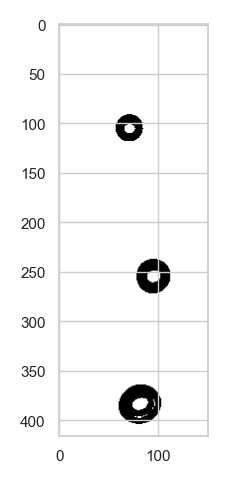

In [ ]:
plt.imshow(
    get_dataset(EXAMPLE_UNOBSRUCTED_VIDEO, frame=islice[:200:50])["video"]
    .sel(**COMMON)
    .min("frame")
    .values
)

HIDE

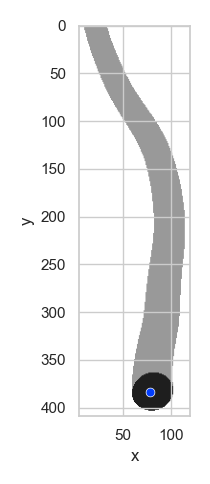

In [ ]:
video = scale_bool(
    get_dataset(EXAMPLE_UNOBSRUCTED_VIDEO, stage="filled", frame=FRAMES)["video"]
).sel(**COMMON)
# first_frame = transform(video.sel(frame=0).values, Transform(Op.open, 7))
first_frame = video.sel(frame=0).values

with nowarn():
    first_frame_objects = tp.locate(first_frame, diameter=DIAMETER)

ax = show_initial_and_path(video)
with catch_warnings(category=UserWarning, action="ignore"):
    sns.scatterplot(
        ax=ax,
        data=first_frame_objects,
        x="x",
        y="y",
        s=40,
        legend=False,  # type: ignore  # pyright 1.1.311
    )

HIDE

In [ ]:
objects = tp.link(
    f=tp.batch(frames=video.values, diameter=DIAMETER), search_range=20, memory=3
)

In [ ]:
with style_df(
    objects.set_index(["particle", "frame"])
    .also(lambda df: display(df.agg(["max", "median"])))[["x", "y", "size"]]  # type: ignore
    .sample(10, random_state=0)
    .sort_index()
) as styler:
    styler.background_gradient()

,y,x,mass,size,ecc,signal,raw_mass,ep
max,383.8,98.53,1.639e+05,15.44,0.08498,211.0,2.930e+05,0.000
median,228.6,89.69,1.418e+05,12.64,0.05643,177.8,2.231e+05,0.000


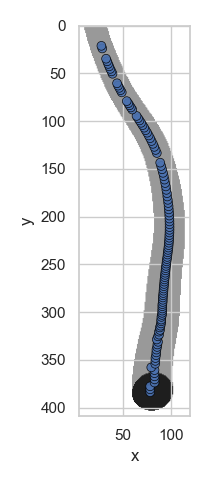

In [ ]:
ax = show_initial_and_path(video)
with catch_warnings(category=UserWarning, action="ignore"):
    sns.scatterplot(
        ax=ax,
        data=objects,
        x="x",
        y="y",
        hue="particle",
        s=40,
        edgecolor="black",
        alpha=0.9,
        palette=sns.color_palette("deep"),
        legend=False,  # type: ignore  # pyright 1.1.311
    )

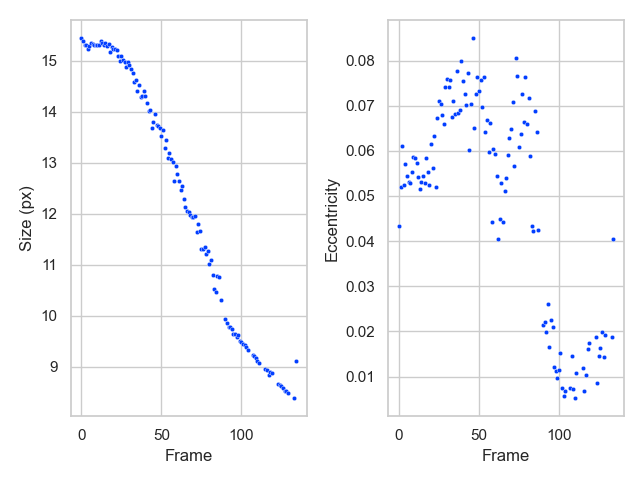

In [ ]:
name = {"size": "Size", "ecc": "Eccentricity"}
units = {
    name: f" ({unit})" if unit else ""
    for name, unit in {"size": "px", "ecc": ""}.items()
}
_, axs = plt.subplot_mosaic([list(name.keys())])
for y, ax in axs.items():
    ax.set_ylabel(f"{name[y]}{units[y]}")  # type: ignore  # pyright 1.1.311, note: incorrect `subplot_mosaic` stub
    sns.scatterplot(
        ax=ax,
        data=objects.rename(columns=name | {"frame": "Frame"}),
        x="Frame",
        s=10,
        y=name[y],  # type: ignore  # pyright 1.1.311
        legend=False,  # type: ignore  # pyright 1.1.311, note: incorrect `subplot_mosaic` stub
    )

# Correlations

One correlation for bubble history of direct contact condensation of vapor bubbles in a subcooled liquid such considers a stagnant bubble in liquid dominated by heat transfer, which can be represented as

$$
\beta = 1 - 4Ja\sqrt\frac{Fo_0}{\pi}
$$

where $\beta$ is the dimensionless bubble diameter $D/D_0$ with $D_0$ being the initial bubble diameter, $Ja$ is the Jakob number $\rho_l c_{pl}\Delta T_{sub}/\rho_v h_{fg}$ , and $Fo_0$ is the Fourier number $\alpha t/D_{b0}^2$ . [@tangReviewDirectContact2022; @florschuetzMechanicsVaporBubble1965]


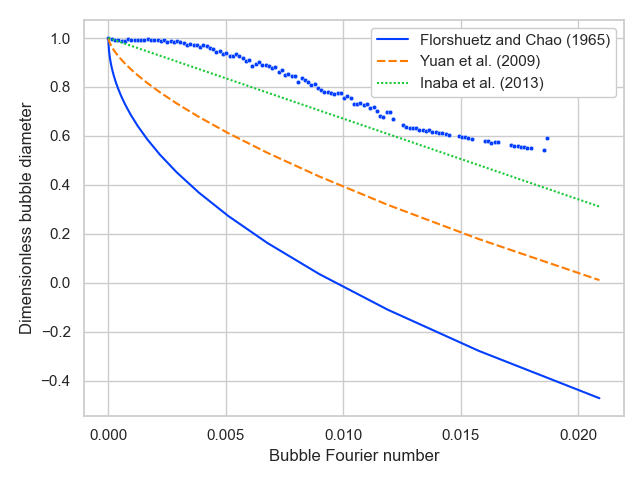

In [ ]:
time = np.logspace(-6, 0) / 8  # s
initial_bubble_diameter = 1e-3  # m
initial_bubble_velocity = 0.7e-2  # m/s
subcooling = 2  # K

latent_heat_of_vaporization = 2.23e6  # J/kg
liquid_density = 960  # kg/m^3
liquid_dynamic_viscosity = 2.88e-4  # Pa-s
liquid_isobaric_specific_heat = 4213  # J/kg-K
liquid_thermal_conductivity = 0.676  # W/m-K
vapor_density = 0.804  # kg/m^3

liquid_kinematic_viscosity = kinematic_viscosity(
    density=liquid_density, dynamic_viscosity=liquid_dynamic_viscosity
)
liquid_thermal_diffusivity = thermal_diffusivity(
    thermal_conductivity=liquid_thermal_conductivity,
    density=liquid_density,
    isobaric_specific_heat=liquid_isobaric_specific_heat,
)

bubble_initial_reynolds = reynolds(
    velocity=initial_bubble_velocity,
    characteristic_length=initial_bubble_diameter,
    kinematic_viscosity=liquid_kinematic_viscosity,
)
liquid_prandtl = prandtl(
    dynamic_viscosity=liquid_dynamic_viscosity,
    isobaric_specific_heat=liquid_isobaric_specific_heat,
    thermal_conductivity=liquid_thermal_conductivity,
)
bubble_jakob = jakob(
    liquid_density=liquid_density,
    vapor_density=vapor_density,
    liquid_isobaric_specific_heat=liquid_isobaric_specific_heat,
    subcooling=subcooling,
    latent_heat_of_vaporization=latent_heat_of_vaporization,
)
bubble_fourier = fourier(
    liquid_thermal_diffusivity=liquid_thermal_diffusivity,
    initial_bubble_diameter=initial_bubble_diameter,
    time=time,
)

fig, ax = plt.subplots()
ax.set_xlabel("Bubble Fourier number")
ax.set_ylabel("Dimensionless bubble diameter")
sns.lineplot(
    ax=ax,
    data=(
        pd.DataFrame(index=bubble_fourier).assign(  # type: ignore  # pyright: 1.1.311
            **{
                "Florshuetz and Chao (1965)": dimensionless_bubble_diameter_florschuetz(
                    jakob=bubble_jakob, fourier=bubble_fourier
                ),
                "Yuan et al. (2009)": dimensionless_bubble_diameter_yuan(
                    bubble_initial_reynolds=bubble_initial_reynolds,
                    liquid_prandtl=liquid_prandtl,
                    bubble_jakob=bubble_jakob,
                    bubble_fourier=bubble_fourier,
                ),
                "Inaba et al. (2013)": dimensionless_bubble_diameter_inaba(
                    bubble_initial_reynolds=bubble_initial_reynolds,
                    liquid_prandtl=liquid_prandtl,
                    bubble_jakob=bubble_jakob,
                    bubble_fourier=bubble_fourier,
                ),
            }
        )
    ),
)
sns.scatterplot(
    ax=ax,
    s=10,
    data=objects[["frame", "size"]]
    .assign(
        **{
            "bubble_fourier": fourier(
                initial_bubble_diameter=initial_bubble_diameter,
                liquid_thermal_diffusivity=liquid_thermal_diffusivity,
                time=video.sel(frame=objects["frame"].values)["time"],
            ),
            "dimensionless_bubble_diameter": lambda df: df["size"] / df["size"][0],
        }
    )
    .set_index("bubble_fourier")["dimensionless_bubble_diameter"],
)
HIDE